## COSC2999:Pratical Data Science
## Assignment 3: Group Project
### Group 6:
Vu Quoc Gia Quan - s3927120

### Project Goal:
- Develop and compare at least 2 models to predict Revenue attribute in Online Shoppers Purchasing Intention Dataset from (https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset)
- Implement at least 2 clustering algorithm for the dataset
- Enhance model performance by adding cluster labels as additional features and evaluate their impact on model accuracy

## Task 1: Retrieving and Preparing the Data

In [1]:
import pandas as pd

In [2]:
# Load and make a deep copy of the dataset
df_raw = pd.read_csv("online_shoppers_intention.csv")
df = df_raw.copy(deep=True) 

In [3]:
# Quick overview
print("Shape :", df.shape)
print("Types : ", df.dtypes)
display(df.head(3))


Shape : (12330, 18)
Types :  Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [4]:
# Remove leading and trailing white spaces from columns' name
df.columns.str.strip()

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

All columns name look normal thorugh observation.

In [5]:
# SIMPLE STRUCTURAL CHECKS
# missing values
missing = df.isna().sum()
print("\nMissing values (non-zero only):")
print(missing[missing > 0])

# 3.3 duplicates
dup_count = df.duplicated().sum()
print("\nExact duplicate rows:", dup_count)



Missing values (non-zero only):
Series([], dtype: int64)

Exact duplicate rows: 125


We checked for missing value and found none in the dataset but there was 125 duplicates entries.

In [6]:
# drop duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Removed {before-after} duplicate rows. New shape: {df.shape}")


Removed 125 duplicate rows. New shape: (12205, 18)


These duplicates were removed and the datashape change from (12330,18) to (12205,18).

In [7]:
# Check some basic info about datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int64  
 14  TrafficType           

We can obseerve that most data are in integer and float datatype while "Month" and "VisitorType" are object datatype. We also see that "Weekend" and "Revenue" are in boolean datatype. These will be addressed during feature engineering.

In [8]:
# Check for unique values in attributes with object datatype
for c in df.select_dtypes(include="object"):
    df[c] = df[c].str.strip().str.lower()
    print(f"Unique values in '{c}': {df[c].unique()}")

Unique values in 'Month': ['feb' 'mar' 'may' 'oct' 'june' 'jul' 'aug' 'nov' 'sep' 'dec']
Unique values in 'VisitorType': ['returning_visitor' 'new_visitor' 'other']


In [9]:
# Check for empty string in dataset
(df == "").any(axis=1).sum()

np.int64(0)

After checking for empty strings, we confirmed that the data have no such entries.

In [10]:
# Use descriptive statistic to check for abnormalities
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,2.338878,81.646331,0.508726,34.825454,32.045637,1206.982457,0.020370,0.041466,5.949574,0.061942,2.124211,2.357804,3.153298,4.073904
std,3.330436,177.491845,1.275617,141.424807,44.593649,1919.601400,0.045255,0.046163,18.653671,0.199666,0.906823,1.710114,2.402340,4.016654
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,193.000000,0.000000,0.014231,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,608.942857,0.002899,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.700000,0.000000,0.000000,38.000000,1477.154762,0.016667,0.048529,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [11]:
# Define continuous attribute
continuous_cols = ["Administrative", 
                   "Administrative_Duration", 
                   "Informational", 
                   "Informational_Duration", 
                   "ProductRelated", 
                   "ProductRelated_Duration", 
                   "BounceRates", 
                   "ExitRates", 
                   "PageValues", 
                   "SpecialDay"]

In [12]:
# Define categorical attribute
categorical_cols = ["Month", 
                    "OperatingSystems",
                    "VisitorType",
                    "Browser",
                    "Region",
                    "TrafficType",
                    "Weekend",
                    "Revenue"]

In [13]:
# Calculate Q1, Q3, and IQR for all continuous columns
Q1 = df[continuous_cols].quantile(0.25)
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create a DataFrame showing whether each value is an outlier (True/False)
outlier_flags = (df[continuous_cols] < lower) | (df[continuous_cols] > upper)

# Optionally, count how many outliers per column
outlier_counts = outlier_flags.sum()

print("Outlier counts per column:\n", outlier_counts)

# If you want to see the actual rows with any outliers:
outlier_rows = df[outlier_flags.any(axis=1)]


Outlier counts per column:
 Administrative              404
Administrative_Duration    1149
Informational              2631
Informational_Duration     2405
ProductRelated             1007
ProductRelated_Duration     951
BounceRates                1428
ExitRates                  1325
PageValues                 2730
SpecialDay                 1249
dtype: int64


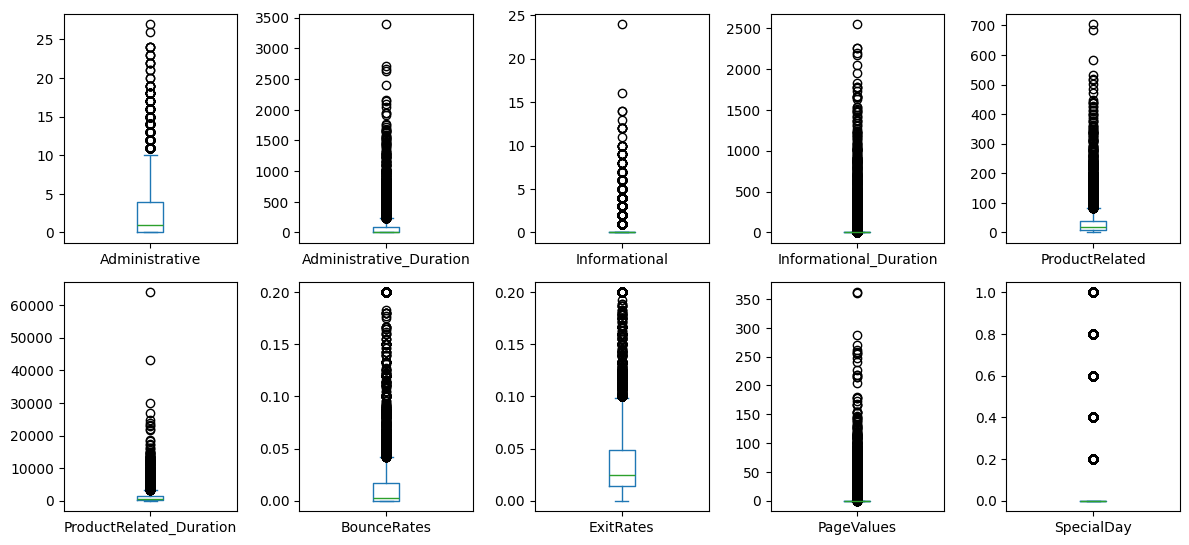

In [14]:
import matplotlib.pyplot as plt

df[continuous_cols].plot(kind="box", subplots=True, layout=(3,5), figsize=(12,8))
plt.tight_layout()


There were a lot of outliers in continuous attribute which could skew our model's performance. These will be dealt with during feature engineering.

## <u>Task 2 — Feature Engineering (transformations + feature selection)</u>
We now define consistent preprocessing for **classification** and **clustering** using sklearn Pipelines.

Principles:
- Keep preprocessing inside a Pipeline/ColumnTransformer to ensure consistency across splits.
- Perform feature selection based on training data only.


### __2.1 - Train / Validation / Test split__
The dataset was split into training (70%), validation (15%), and test (15%) sets using stratified sampling to preserve the class distribution of the target variable. This ensured unbiased model evaluation and prevented information leakage during feature engineering and model selection.

In [15]:
from sklearn.model_selection import train_test_split

TARGET = "Revenue"
RANDOM_STATE = 42

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (8543, 17)
Val:   (1831, 17)
Test:  (1831, 17)


### __2.2 - Feature grouping__
Different features need different transformations. Treating everything the same hurts performance and interpretability.

In [16]:
# Count features (zero-inflated, integer)
count_features = [
    "Administrative", "Informational", "ProductRelated"
]

# Duration & value features (heavy-tailed)
duration_features = [
    "Administrative_Duration", "Informational_Duration",
    "ProductRelated_Duration", "PageValues"
]

# Rate / bounded features
rate_features = [
    "BounceRates", "ExitRates", "SpecialDay"
]

# Encoded categoricals (already numeric labels, NOT ordinal)
encoded_cat_features = [
    "OperatingSystems", "Browser", "Region", "TrafficType"
]

# True categoricals
categorical_features = [
    "Month", "VisitorType"
]

# Binary
binary_features = ["Weekend"]


### __2.3 - Feature transformation choices / Preprocessing pipelines__

#### 2.3.1 Log-transform heavy-tailed features

Durations and PageValues have extreme outliers. Log transform:
- stabilizes variance
- reduces dominance of extreme values
- helps linear & distance-based models

We use log1p to handle zeros safely.

#### 2.3.2 Scaling

Required for clustering (distance-based)

Optional but helpful for classification models

We use StandardScaler.

#### 2.3.3 Encoding categoricals

Month, VisitorType → OneHotEncoder

Encoded numeric categories (Browser, Region, etc.) → treat as categorical. These can be kept as categorical as to not over inflate the dataset

Why not leave them numeric?
Their numeric labels have no order meaning. Leaving them numeric introduces fake ordinal relationships.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
import numpy as np

log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

numeric_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

rate_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess_classification = ColumnTransformer(
    transformers=[
        ("counts", numeric_pipeline, count_features),
        ("durations", numeric_pipeline, duration_features),
        ("rates", rate_pipeline, rate_features),
        ("encoded_cat", "passthrough", encoded_cat_features),
        ("categorical", categorical_pipeline, categorical_features),
        ("binary", "passthrough", binary_features),
    ],
    remainder="drop"
)

### __2.4 - Clustering preprocessing pipeline__

Differences from classification:

- No target
- Scaling is mandatory
- Same transformations → consistency

In [18]:
preprocess_clustering = ColumnTransformer(
    transformers=[
        ("counts", numeric_pipeline, count_features),
        ("durations", numeric_pipeline, duration_features),
        ("rates", rate_pipeline, rate_features),
        ("encoded_cat", "passthrough", encoded_cat_features),
        ("categorical", categorical_pipeline, categorical_features),
        ("binary", "passthrough", binary_features),
    ],
    remainder="drop"
)

#### __2.5 - Correlation with target (classification)__

What you should observe:

- PageValues (log) → strong positive correlation
- Duration-related features → moderate
- BounceRates / ExitRates → negative

In [19]:
X_train_processed = preprocess_classification.fit_transform(X_train)
feature_names = preprocess_classification.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
corr_with_target = X_train_df.corrwith(y_train).sort_values(key=np.abs, ascending=False)

X_val_processed = preprocess_classification.transform(X_val)
X_val_df = pd.DataFrame(X_val_processed, columns=feature_names)

corr_with_target.head(25)


counts__Administrative                       -0.033015
counts__ProductRelated                       -0.031317
durations__Administrative_Duration           -0.029754
durations__ProductRelated_Duration           -0.026999
rates__ExitRates                              0.023563
encoded_cat__TrafficType                      0.021816
rates__BounceRates                            0.019361
categorical__Month_may                       -0.016908
encoded_cat__Region                          -0.014147
binary__Weekend                              -0.012660
categorical__Month_sep                        0.011605
durations__PageValues                         0.009795
counts__Informational                        -0.009353
durations__Informational_Duration            -0.007811
categorical__Month_mar                        0.007793
categorical__Month_dec                        0.006348
categorical__Month_jul                       -0.006295
categorical__Month_june                       0.005693
encoded_ca

### __2.6 - Redundancy check__


In [20]:
corr_matrix = X_train_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, upper[col].idxmax(), upper[col].max())
    for col in upper.columns if upper[col].max() > 0.9
]

high_corr_pairs[:10]


[('durations__Administrative_Duration',
  'counts__Administrative',
  np.float64(0.9262012075392478)),
 ('durations__Informational_Duration',
  'counts__Informational',
  np.float64(0.9162024425751121)),
 ('categorical__VisitorType_returning_visitor',
  'categorical__VisitorType_new_visitor',
  np.float64(0.9707061326291561))]

__Decision rationale:__
- No features removed yet
- Strong predictors retained (PageValues, durations)
- Redundancy will be handled by:
- regularization (classification)
- PCA / clustering robustness (later)

In Task 2, feature engineering was performed using sklearn pipelines to ensure consistent transformations across training, validation, and test sets. Features were grouped by semantic type and transformed accordingly. Heavy-tailed duration and value variables were log-transformed, categorical variables were one-hot encoded, and all numeric features were scaled. Feature relevance was evaluated using correlation analysis on the training set only, confirming PageValues and session duration variables as strong predictors of purchase intent. No features were removed at this stage to preserve information for downstream models.

In [21]:
df["Revenue"].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

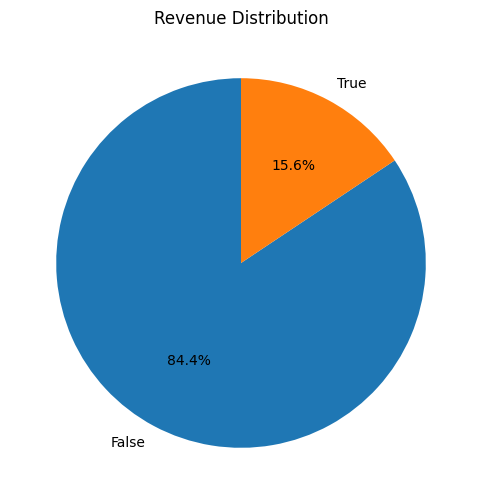

In [22]:
# 1. Pie Chart (e.g., Gender distribution)
gender_counts = df['Revenue'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Revenue Distribution')
plt.show()


In [23]:
# Check Revenue distribution (imbalance)
print("Revenue distribution before balancing:")
print(df["Revenue"].value_counts())
print("\nPercentage distribution:")
print(df["Revenue"].value_counts(normalize=True) * 100)

Revenue distribution before balancing:
Revenue
False    10297
True      1908
Name: count, dtype: int64

Percentage distribution:
Revenue
False    84.367063
True     15.632937
Name: proportion, dtype: float64


There is a high imbalance within Revenue with True being only 15.6% and False being 84.4%

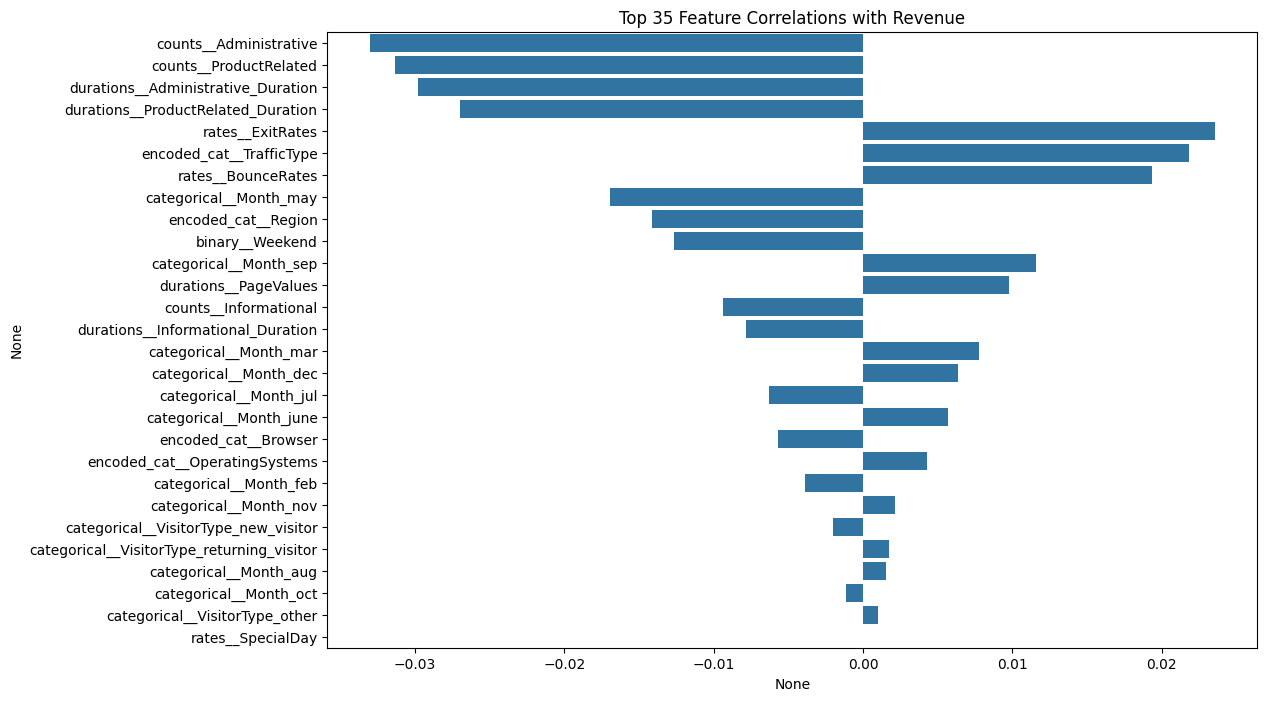

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the correlation matrix
corr_with_target = X_train_df.corrwith(y_train).sort_values(key=np.abs, ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x=corr_with_target.head(35), y=corr_with_target.head(35).index)
plt.title("Top 35 Feature Correlations with Revenue")
plt.show()

We decided to use recursive feature elimination with cross validation to select the best feature after preprocessing.  
https://www.geeksforgeeks.org/machine-learning/recursive-feature-elimination-with-cross-validation-in-scikit-learn/

In [25]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


# RFECV automatically selects the optimal number of features using CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    step=1,
    cv=cv,
    scoring='f1'   
)

# Fit RFECV
X_train_selected = rfecv.fit_transform(X_train_df, y_train)
X_val_selected = rfecv.transform(X_val_df)

# Get selected feature names
selected_columns = X_train_df.columns[rfecv.support_]

# Convert back into DataFrames
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns)
X_val_selected_df = pd.DataFrame(X_val_selected, columns=selected_columns)

# Print results
print("Original shape:", X_train_df.shape)
print("Reduced shape:", X_train_selected.shape)
print("Optimal number of features selected:", rfecv.n_features_)
print("Selected features:", list(selected_columns))


Original shape: (8543, 28)
Reduced shape: (8543, 19)
Optimal number of features selected: 19
Selected features: ['counts__Administrative', 'counts__ProductRelated', 'durations__Administrative_Duration', 'durations__PageValues', 'rates__BounceRates', 'rates__ExitRates', 'categorical__Month_aug', 'categorical__Month_dec', 'categorical__Month_feb', 'categorical__Month_jul', 'categorical__Month_june', 'categorical__Month_mar', 'categorical__Month_may', 'categorical__Month_nov', 'categorical__Month_oct', 'categorical__Month_sep', 'categorical__VisitorType_new_visitor', 'categorical__VisitorType_returning_visitor', 'binary__Weekend']


We will be reusing some old functions from our teammate previous assignment to train and save models as well as visualize performance

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Build a model to train and save model
def train_and_save(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc,3))
    
    # Collect metrics
    results_dict[model_name] = {
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return model, results_dict

In [27]:
# Build a function to train and save functions afer running GridSearchCV
def train_and_save_hyper(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))

    print("Best parameters found: ", model.best_params_)
    print("Best cross-validation score: ", model.best_score_)
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc,3))
    
    # Collect metrics
    results_dict[model_name] = {
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return model, results_dict

In [28]:
# Function to plot classification results
def plot_classification_results(results_df):
    plt.figure(figsize=(20, 10))
    ax = results_df[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar', figsize=(20, 10))
    plt.title('Classification Model Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
     # Add value labels 
    for p in ax.patches: 
        height = p.get_height() 
        percent = height * 100
        ax.annotate(f'{percent:.1f}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=9)
    plt.show()

### Classification task:

To address the significant class imbalance in Revenue, we applies Synthetic Minority Oversampling Technique (SMOTE) to the training data which generate synthetic samples of minority class.  
https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c

In [29]:
# Using SMOTE to fix class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)

X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)
results_class = {}

We chose four models. The first is Logistic Regression as a baseline due to its simplicity and interpretability. The second is Random Forest Classifier as an intermediate model with enhanced performance through ensemble learning. Finally, we implemented a hybrid ensemble that integrate Random Forest and Gradient Boosting as well as Logistic Regression and Gradient Boosting to increase performance by combining their strength.

We optimized the models by using GridSearchCV which perform search over predefined parameters grid. The parameters range were selected from official Sci-kit learn library documentation.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

# Logistic Regression with hyperparameter tuning
params_log = {
    'C': [0.001, 0.01, 0.1, 1, 5],
    'solver': ['lbfgs'],
    'max_iter': [100,200,500]
}
skf = StratifiedKFold(n_splits = 10)
LR_hyper = GridSearchCV(LR, param_grid = params_log, n_jobs =-1, cv = skf)
model_LogR_hyper, results_class = train_and_save_hyper(LR_hyper, X_train_smote, y_train_smote, X_val_selected, y_val, "Logistic Regression Tuned", results_class)

Model accuracy for train set: 0.843
Model accuracy for test set: 0.878
Best parameters found:  {'C': 0.001, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validation score:  0.8432776591229121

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1545
           1       0.58      0.78      0.67       286

    accuracy                           0.88      1831
   macro avg       0.77      0.84      0.80      1831
weighted avg       0.90      0.88      0.88      1831


Confusion Matrix:
 [[1384  161]
 [  63  223]]

Accuracy Score:  0.878


Random Forest

In [31]:
# Random Forest with hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Parameter are choses based on definition from SKLearn library
params_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [4, 7, 10],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Hyperparameter tunning using GridSearchCV
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
RF_hyper = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid=params_rf, n_jobs=-1, cv=skf)
model_RF_hyper, results_class = train_and_save_hyper(
    RF_hyper, X_train_smote, y_train_smote, X_val_selected, y_val, "Random Forest Tuned", results_class
)

c:\Users\felwi\Documents\GitHub\rmit_pds_asm3\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model accuracy for train set: 0.953
Model accuracy for test set: 0.871
Best parameters found:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score:  0.9145971792973941

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1545
           1       0.56      0.78      0.65       286

    accuracy                           0.87      1831
   macro avg       0.76      0.84      0.79      1831
weighted avg       0.90      0.87      0.88      1831


Confusion Matrix:
 [[1371  174]
 [  62  224]]

Accuracy Score:  0.871


Hybrid Ensemble

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Build a simple GradientBoostingClassifer
gb = GradientBoostingClassifier()

params_gb = {
    'n_estimators': [100, 200, 300],       # number of boosting stages
    'learning_rate': [0.05, 0.1, 0.01],     # step size shrinkage
    'max_depth': [3, 5],              # depth of individual trees
}
gb_hyper = GridSearchCV(GradientBoostingClassifier(), param_grid=params_gb, n_jobs=-1, cv=skf)
model_GB_hyper, _ = train_and_save_hyper(
    gb_hyper, X_train_smote, y_train_smote, X_val_selected, y_val, "Gradient Boosting Tuned", _
)

c:\Users\felwi\Documents\GitHub\rmit_pds_asm3\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model accuracy for train set: 0.971
Model accuracy for test set: 0.882
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best cross-validation score:  0.9265304953698937

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1545
           1       0.61      0.70      0.65       286

    accuracy                           0.88      1831
   macro avg       0.77      0.81      0.79      1831
weighted avg       0.89      0.88      0.89      1831


Confusion Matrix:
 [[1414  131]
 [  85  201]]

Accuracy Score:  0.882


In [33]:
from sklearn.ensemble import VotingClassifier

# Combine the two models into one using VotingClassifier
hybrid_model = VotingClassifier(
    estimators=[('rf', model_RF_hyper.best_estimator_), ('gb', model_GB_hyper.best_estimator_)],
    voting='soft',
    weights=[1,1.5]
)

hybrid_model_trained, results_class = train_and_save(
    hybrid_model, X_train_smote, y_train_smote, X_val_selected, y_val, "Hybrid Model RF-GB", results_class
)


Model accuracy for train set: 0.969
Model accuracy for test set: 0.886

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1545
           1       0.61      0.73      0.67       286

    accuracy                           0.89      1831
   macro avg       0.78      0.82      0.80      1831
weighted avg       0.90      0.89      0.89      1831


Confusion Matrix:
 [[1414  131]
 [  78  208]]

Accuracy Score:  0.886


In [34]:
# Combine the two models into one using VotingClassifier
hybrid_model = VotingClassifier(
    estimators=[('lr', model_LogR_hyper.best_estimator_), ('gb', model_GB_hyper.best_estimator_)],
    voting='soft',
    weights=[1,1.5]
)

hybrid_model_trained, results_class = train_and_save(
    hybrid_model, X_train_smote, y_train_smote, X_val_selected, y_val, "Hybrid Model LR-GB", results_class
)


Model accuracy for train set: 0.956
Model accuracy for test set: 0.887

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1545
           1       0.61      0.76      0.68       286

    accuracy                           0.89      1831
   macro avg       0.78      0.83      0.80      1831
weighted avg       0.90      0.89      0.89      1831


Confusion Matrix:
 [[1407  138]
 [  69  217]]

Accuracy Score:  0.887


Next is the clustering task, we decided to use k-means clustering and DBScan.

### Clustering task

We choose KMeans and DBSCAN as our clustering models. Their cluster quality will be judge silhouette coefficients score to check for how well cluster separation (with values ranging from -1 to 1, where higher values indicate better-defined clusters) and Davies-Bouldin Index to assess cluster compactness and separation (where lower values indicate better clustering, with 0 being optimal).   
https://www.geeksforgeeks.org/machine-learning/silhouette-algorithm-to-determine-the-optimal-value-of-k/  
https://www.geeksforgeeks.org/machine-learning/davies-bouldin-index/

In [35]:
# Rerun the preprocessing using clustering pipeline instead
X_train_processed_cluster = preprocess_clustering.fit_transform(X_train)
feature_names = preprocess_clustering.get_feature_names_out()

# Convert them into dataframe so that we can use them later on
X_train_df_cluster = pd.DataFrame(X_train_processed_cluster, columns=feature_names)

X_val_processed_cluster = preprocess_clustering.transform(X_val)
X_val_df_cluster = pd.DataFrame(X_val_processed_cluster, columns=feature_names)

In [36]:
# RFECV automatically selects the optimal number of features using CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    step=1,
    cv=cv,
    scoring='f1'   # you can change to 'f1' if imbalance is important
)

# Fit RFECV
X_train_selected_cluster = rfecv.fit_transform(X_train_df_cluster, y_train)
X_val_selected_cluster = rfecv.transform(X_val_df_cluster)

# Get selected feature names
selected_columns = X_train_df_cluster.columns[rfecv.support_]

# Convert back into DataFrames
X_train_selected_cluster_df = pd.DataFrame(
    X_train_selected_cluster, 
    columns=selected_columns
)
X_val_selected_cluster_df = pd.DataFrame(
    X_val_selected_cluster, 
    columns=selected_columns
)


# Print results
print("Original shape:", X_train_df_cluster.shape)
print("Reduced shape:", X_train_selected_cluster.shape)
print("Optimal number of features selected:", rfecv.n_features_)
print("Selected features:", list(selected_columns))


Original shape: (8543, 28)
Reduced shape: (8543, 19)
Optimal number of features selected: 19
Selected features: ['counts__Administrative', 'counts__ProductRelated', 'durations__Administrative_Duration', 'durations__PageValues', 'rates__BounceRates', 'rates__ExitRates', 'categorical__Month_aug', 'categorical__Month_dec', 'categorical__Month_feb', 'categorical__Month_jul', 'categorical__Month_june', 'categorical__Month_mar', 'categorical__Month_may', 'categorical__Month_nov', 'categorical__Month_oct', 'categorical__Month_sep', 'categorical__VisitorType_new_visitor', 'categorical__VisitorType_returning_visitor', 'binary__Weekend']


To judge cluster quality, we decided to use silhouette_score from SkLearn

#### KMeans:

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Try different k values
results = {}

# Test for k from 2 to 16
for k in range(2, 16): 
    kmeans_tmp = KMeans(n_clusters=k, random_state=0)
    labels_tmp = kmeans_tmp.fit_predict(X_train_selected_cluster_df)

    sil_score = silhouette_score(X_train_selected_cluster_df, labels_tmp)
    dbi_score = davies_bouldin_score(X_train_selected_cluster_df, labels_tmp)

    results[k] = {"silhouette": sil_score, "DBI": dbi_score}
    print(f"k={k}, silhouette={sil_score:.3f}, DBI={dbi_score:.3f}")

# Print all results for manual inspection
print("All scores:", results)

k=2, silhouette=0.443, DBI=0.805
k=3, silhouette=0.314, DBI=1.112
k=4, silhouette=0.303, DBI=1.210
k=5, silhouette=0.256, DBI=1.367
k=6, silhouette=0.260, DBI=1.404
k=7, silhouette=0.213, DBI=1.488
k=8, silhouette=0.194, DBI=1.543
k=9, silhouette=0.195, DBI=1.580
k=10, silhouette=0.186, DBI=1.605
k=11, silhouette=0.178, DBI=1.686
k=12, silhouette=0.177, DBI=1.697
k=13, silhouette=0.173, DBI=1.733
k=14, silhouette=0.168, DBI=1.743
k=15, silhouette=0.165, DBI=1.731
All scores: {2: {'silhouette': 0.4431824073825857, 'DBI': 0.8054685315442063}, 3: {'silhouette': 0.31435004205112405, 'DBI': 1.1117064390870475}, 4: {'silhouette': 0.30293909160951776, 'DBI': 1.2103793235421336}, 5: {'silhouette': 0.2557511202944989, 'DBI': 1.3674874918762794}, 6: {'silhouette': 0.2596679897117336, 'DBI': 1.4044748861592797}, 7: {'silhouette': 0.2130015092797421, 'DBI': 1.4879135226130142}, 8: {'silhouette': 0.1937594988574302, 'DBI': 1.5432099282561795}, 9: {'silhouette': 0.19468420132479936, 'DBI': 1.5804161

We found that k = 2 is the best option for K-Means

In [39]:
# K-Means Clustering
from sklearn.cluster import KMeans

# --- Clustering on selected features ---
kmeans = KMeans(n_clusters=2, random_state=0)
train_clusters = kmeans.fit_predict(X_train_selected_cluster_df)
val_clusters = kmeans.predict(X_val_selected_cluster_df)

# Add cluster labels as new feature
X_train_selected_cluster_df["KMeans_Cluster"] = train_clusters
X_val_selected_cluster_df["KMeans_Cluster"] = val_clusters


#### DBSCAN:

In [42]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
eps_values = np.arange(0.5,4,0.5)    
min_samples_values = np.arange(2,11,1)            

# Loop over all combinations and just print results
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_train_selected_cluster_df)

        # Skip cases where DBSCAN assigns all points to noise (-1) or only one cluster
        if len(set(labels)) > 1 and not all(l == -1 for l in labels):
            sil_score = silhouette_score(X_train_selected_cluster_df, labels)
            dbi_score = davies_bouldin_score(X_train_selected_cluster_df, labels)

            print(f"eps={eps}, min_samples={min_samples}, "
                  f"silhouette={sil_score:.3f}, DBI={dbi_score:.3f}")


eps=0.5, min_samples=2, silhouette=-0.071, DBI=1.198
eps=0.5, min_samples=3, silhouette=-0.069, DBI=1.217
eps=0.5, min_samples=4, silhouette=-0.081, DBI=1.238
eps=0.5, min_samples=5, silhouette=-0.094, DBI=1.244
eps=0.5, min_samples=6, silhouette=-0.109, DBI=1.244
eps=0.5, min_samples=7, silhouette=-0.116, DBI=1.228
eps=0.5, min_samples=8, silhouette=-0.124, DBI=1.223
eps=0.5, min_samples=9, silhouette=-0.145, DBI=1.225
eps=0.5, min_samples=10, silhouette=-0.152, DBI=1.235
eps=1.0, min_samples=2, silhouette=-0.178, DBI=1.485
eps=1.0, min_samples=3, silhouette=-0.164, DBI=1.608
eps=1.0, min_samples=4, silhouette=-0.169, DBI=1.640
eps=1.0, min_samples=5, silhouette=-0.168, DBI=1.635
eps=1.0, min_samples=6, silhouette=-0.163, DBI=1.634
eps=1.0, min_samples=7, silhouette=-0.164, DBI=1.665
eps=1.0, min_samples=8, silhouette=-0.160, DBI=1.649
eps=1.0, min_samples=9, silhouette=-0.170, DBI=1.727
eps=1.0, min_samples=10, silhouette=-0.154, DBI=1.763
eps=1.5, min_samples=2, silhouette=0.095, DB

We found that eps = 2.0 have the best silhouette score and stable DBI score with all min_sample from 2-10. We will choose epsilon = 2 and min_samples = 5.

In [43]:
eps, min_samples = 2.0, 5
print("Using eps =", eps, "and min_samples =", min_samples)

# Fit DBSCAN (exclude cluster labels as features)
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
train_clusters_db = dbscan.fit_predict(X_train_selected_cluster_df.drop(columns=["KMeans_Cluster"], errors="ignore"))
val_clusters_db = dbscan.fit_predict(X_val_selected_cluster_df.drop(columns=["KMeans_Cluster"], errors="ignore"))

# Add cluster labels as new featur
X_train_selected_cluster_df["DBSCAN_Cluster"] = train_clusters_db
X_val_selected_cluster_df["DBSCAN_Cluster"] = val_clusters_db

# Show cluster label counts
print('KMeans cluster counts:')
print(X_train_selected_cluster_df['KMeans_Cluster'].value_counts())
print('\nDBSCAN cluster counts (train only):')
print(X_train_selected_cluster_df['DBSCAN_Cluster'].value_counts())

Using eps = 2.0 and min_samples = 5
KMeans cluster counts:
KMeans_Cluster
1    7865
0     678
Name: count, dtype: int64

DBSCAN cluster counts (train only):
DBSCAN_Cluster
 0    8541
-1       2
Name: count, dtype: int64


In [44]:
from sklearn.metrics import silhouette_score

# Prepare features (exclude cluster label columns)
feature_cols_for_sil = X_train_selected_cluster_df.columns.difference(
    ["KMeans_Cluster", "DBSCAN_Cluster"]
)
X_train_features_only = X_train_selected_cluster_df[feature_cols_for_sil]

# KMeans silhouette ---
kmeans_silhouette = silhouette_score(X_train_features_only, train_clusters)
kmeans_dbi = davies_bouldin_score(X_train_features_only, train_clusters)

# DBSCAN silhouette (ignore noise points)
dbscan_mask = train_clusters_db != -1
if dbscan_mask.sum() > 1 and len(set(train_clusters_db[dbscan_mask])) > 1:
    dbscan_silhouette = silhouette_score(
        X_train_features_only[dbscan_mask], train_clusters_db[dbscan_mask]
    )
    dbscan_dbi = davies_bouldin_score(
        X_train_features_only[dbscan_mask], train_clusters_db[dbscan_mask]
    )
else:
    dbscan_silhouette = None
    dbscan_dbi = None

# Compare results
print("Silhouette Score and Davies-Bouldin Index Comparison")
print("---------------------------")
print(f"KMeans: {kmeans_silhouette:.3f}")
print(f"DBI KMeans: {kmeans_dbi:.3f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN: {dbscan_silhouette:.3f}")
    print(f"DBI DBSCAN: {dbscan_dbi:.3f}")
else:
    print("DBSCAN: Not enough clusters formed (all noise or single cluster)")


Silhouette Score and Davies-Bouldin Index Comparison
---------------------------
KMeans: 0.443
DBI KMeans: 0.805
DBSCAN: Not enough clusters formed (all noise or single cluster)


We choose KMeans Clustering because it has better performance

### Retrain new model with cluster label:

In [45]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)

# Using SMOTE to fix data imbalance before training
X_train_for_model = X_train_selected_cluster_df.drop(columns=["DBSCAN_Cluster"], errors="ignore")
X_val_for_model = X_val_selected_cluster_df.drop(columns=["DBSCAN_Cluster"], errors="ignore")

X_train_smote_cluster, y_train_smote_cluster = smote.fit_resample(X_train_for_model, y_train)

In [46]:
# Random Forest with hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

params_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [4, 7, 10],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Hyperparameter tunning using GridSearchCV
skf = StratifiedKFold(n_splits=10)
RF_hyper = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid=params_rf, n_jobs=-1, cv=skf)
model_RF_hyper_cluster, results_class = train_and_save_hyper(
    RF_hyper, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Random Forest Cluster ", results_class
)

c:\Users\felwi\Documents\GitHub\rmit_pds_asm3\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model accuracy for train set: 0.953
Model accuracy for test set: 0.872
Best parameters found:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score:  0.9145320180449505

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1545
           1       0.57      0.78      0.66       286

    accuracy                           0.87      1831
   macro avg       0.76      0.83      0.79      1831
weighted avg       0.90      0.87      0.88      1831


Confusion Matrix:
 [[1374  171]
 [  63  223]]

Accuracy Score:  0.872


In [47]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

params_gb = {
    'n_estimators': [100, 200, 300],       # number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],     # step size shrinkage
    'max_depth': [3, 5, 7],              # depth of individual trees      
}

# Hyperparameter tunning using GridSearchCV
gb_hyper = GridSearchCV(GradientBoostingClassifier(), param_grid=params_gb, n_jobs=-1, cv=skf)
model_GB_hyper_cluster, _ = train_and_save_hyper(
    gb_hyper, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Gradient Boosting Cluster", _
)


c:\Users\felwi\Documents\GitHub\rmit_pds_asm3\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model accuracy for train set: 0.998
Model accuracy for test set: 0.885
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best cross-validation score:  0.9295905236096447

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1545
           1       0.62      0.71      0.66       286

    accuracy                           0.89      1831
   macro avg       0.78      0.81      0.79      1831
weighted avg       0.89      0.89      0.89      1831


Confusion Matrix:
 [[1419  126]
 [  84  202]]

Accuracy Score:  0.885


In [48]:
# Logistic Regression with hyperparameter tuning
params_log = {
    'C': [0.001, 0.01, 0.1, 1, 5],
    'solver': ['lbfgs'],
    'max_iter': [100,200,500]
}
skf = StratifiedKFold(n_splits = 10)
LR_hyper = GridSearchCV(LR, param_grid = params_log, n_jobs =-1, cv = skf)
model_LogR_hyper_cluster, results_class = train_and_save_hyper(LR_hyper, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Logistic Regression Cluster", results_class)

Model accuracy for train set: 0.843
Model accuracy for test set: 0.878
Best parameters found:  {'C': 0.001, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validation score:  0.8432776591229121

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1545
           1       0.58      0.78      0.67       286

    accuracy                           0.88      1831
   macro avg       0.77      0.84      0.80      1831
weighted avg       0.90      0.88      0.88      1831


Confusion Matrix:
 [[1384  161]
 [  63  223]]

Accuracy Score:  0.878


In [49]:
from sklearn.ensemble import VotingClassifier

hybrid_model_cluster = VotingClassifier(
    estimators=[('rf', model_RF_hyper_cluster.best_estimator_), ('gb', model_GB_hyper_cluster.best_estimator_)],
    voting='soft',
    weights=[1,1.5]
)

hybrid_model_cluster_trained, results_class = train_and_save(
    hybrid_model_cluster, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Hybrid Model Cluster RF-GB", results_class
)


Model accuracy for train set: 0.996
Model accuracy for test set: 0.880

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1545
           1       0.60      0.72      0.65       286

    accuracy                           0.88      1831
   macro avg       0.77      0.82      0.79      1831
weighted avg       0.89      0.88      0.88      1831


Confusion Matrix:
 [[1406  139]
 [  80  206]]

Accuracy Score:  0.88


In [50]:
from sklearn.ensemble import VotingClassifier

hybrid_model_cluster = VotingClassifier(
    estimators=[('lr', model_LogR_hyper_cluster.best_estimator_), ('gb', model_GB_hyper_cluster.best_estimator_)],
    voting='soft',
    weights=[1,1.5]
)

hybrid_model_cluster_trained, results_class = train_and_save(
    hybrid_model_cluster, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Hybrid Model Cluster LR-GB", results_class
)


Model accuracy for train set: 0.992
Model accuracy for test set: 0.883

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1545
           1       0.60      0.74      0.66       286

    accuracy                           0.88      1831
   macro avg       0.78      0.82      0.80      1831
weighted avg       0.90      0.88      0.89      1831


Confusion Matrix:
 [[1404  141]
 [  74  212]]

Accuracy Score:  0.883


#### Model performance comparison:

<Figure size 2000x1000 with 0 Axes>

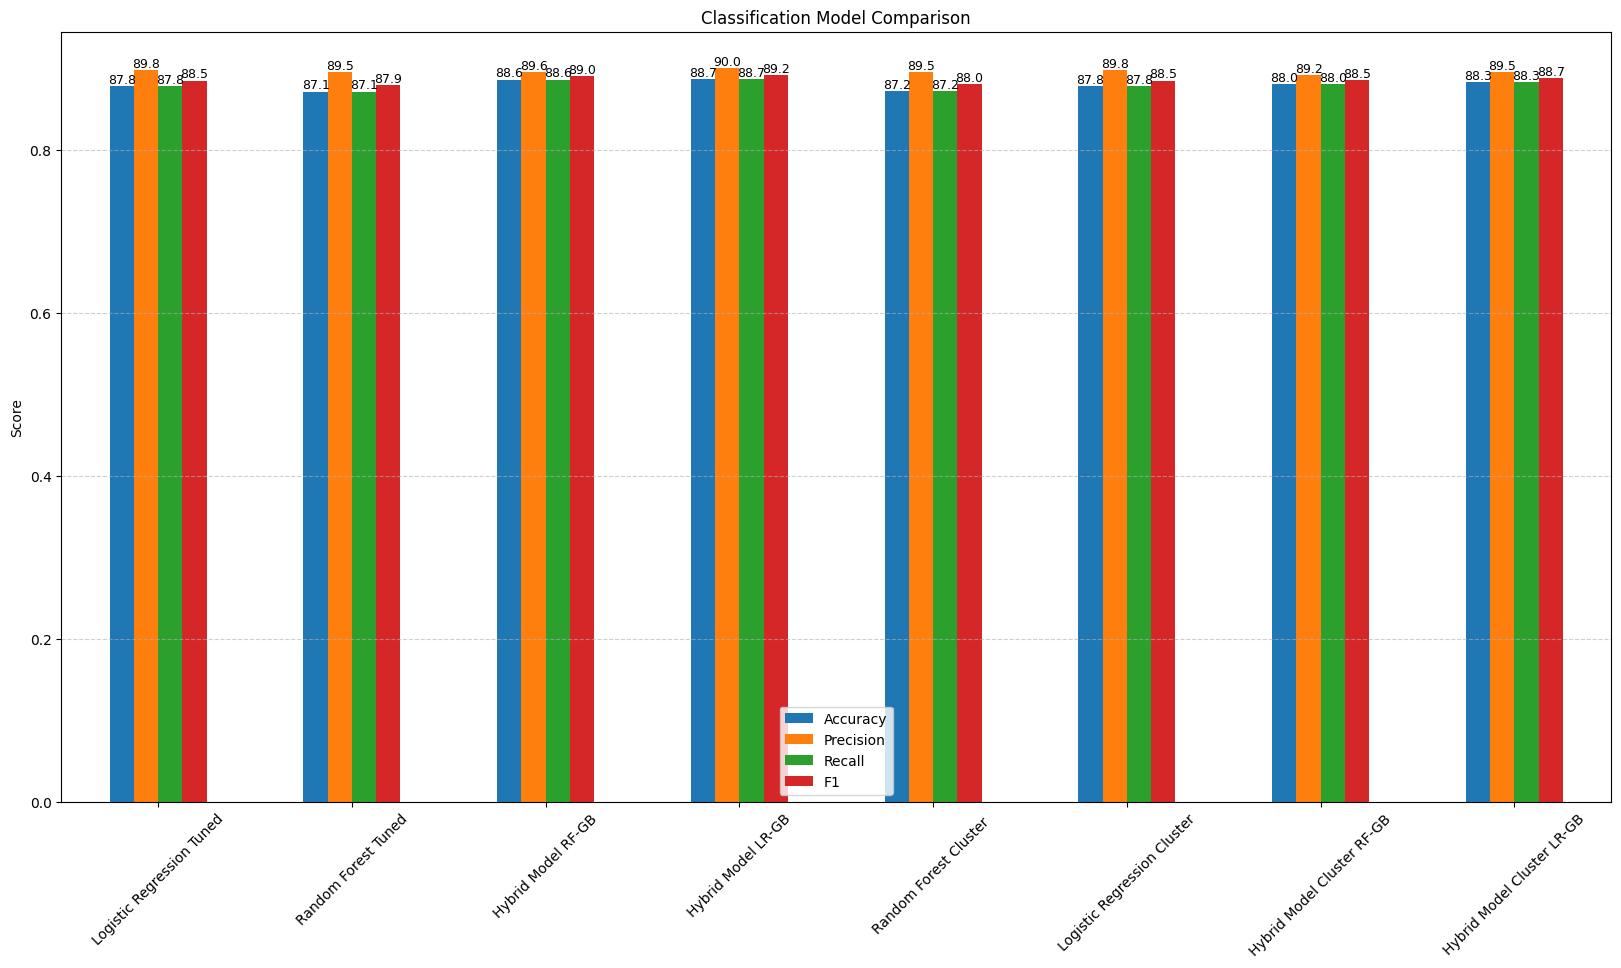

In [51]:
results_class_df = pd.DataFrame(results_class).T

plot_classification_results(results_class_df)